# Capstone Project - Quick, Draw! Doodle Recognition

Google Research has come up with this challenge in Kaggle. Problem statement is to come up with a doodle classifier that can effectively learn from Quick Draw dataset data and perform well on a manually-labeled test set from a different distribution.

I have used the dataset provided along with this challenge in Kaggle (Reference: https://www.kaggle.com/c/quickdraw-doodle-recognition/data)
The part of the dataset that i have used are 'train_simplified' and 'test_simplified.csv'

In [1]:
##importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import ast
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from glob import glob
from PIL import Image, ImageDraw 
from dask import bag
import sys
%matplotlib inline

NUM_CLASS= 340 #total number of categories/classes
size=32 #basic and uniform size of images
imgs_per_class=2000 # number of images per category picked up for training
train_path = 'train_simplified/' #path for input files

## Data Exploration

In [2]:
#total number of files available(i.e total number of categories, one category per file)
input_files = glob(train_path+'*.csv')
len(input_files)

340

In [60]:
#creating a collection of all classes
categories = [file.replace('.csv','').replace(' ','_') for file in os.listdir(train_path)]

### Let's see some sample inputs

In [3]:
# reading top 3 files (3 categories) and picking only top 5 rows
sample_drawings=[pd.read_csv(file,nrows=5) for file in input_files[0:3]]
sample_df = pd.DataFrame(np.concatenate([df[df.recognized==True] for df in sample_drawings]), #filter unrecognized data
                         columns=sample_drawings[0].columns.values)

In [4]:
sample_df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
2,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5643224746033152,True,2017-03-10 00:35:17.531970,airplane
3,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6670046841536512,True,2017-01-23 18:11:11.658170,airplane
4,US,"[[[111, 148, 161, 175, 199, 218, 231, 236, 234...",5159910851477504,True,2017-03-21 13:02:16.246170,alarm clock


In [5]:
sample_diagram_points = [ast.literal_eval(points) for points in sample_df.drawing.values]

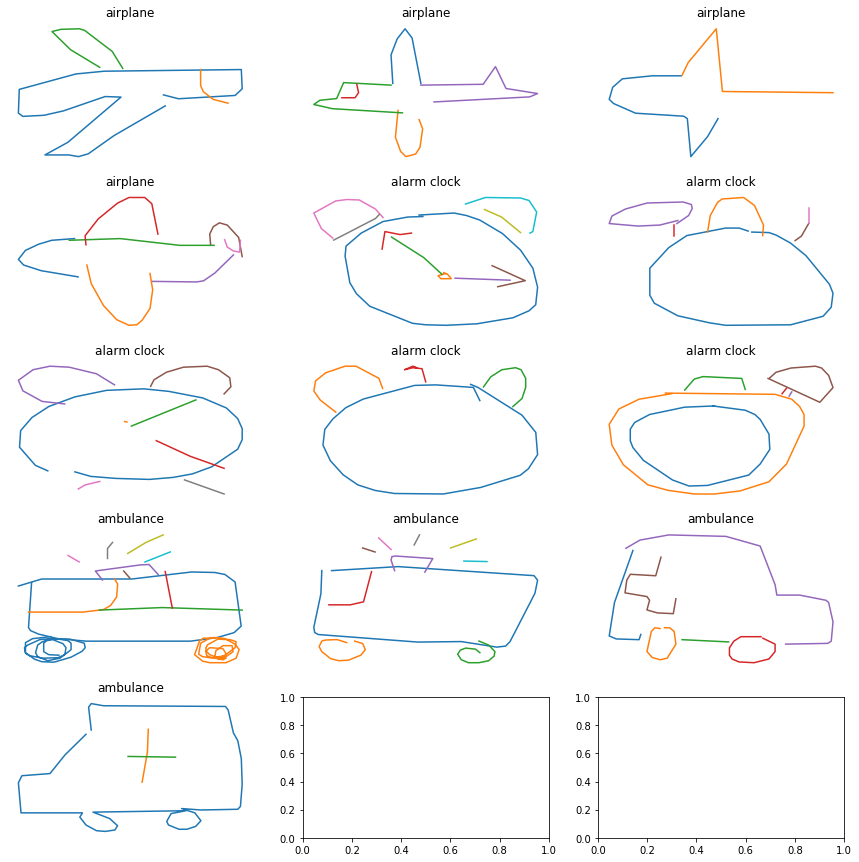

In [6]:
#plotting the sample data
f,axs= plt.subplots(5,3,frameon=False,figsize=(15,15))
for i,drawing in enumerate(sample_diagram_points):
    for j,strokes in enumerate(drawing):
        ax=axs[i//3,i%3]
        ax.plot(strokes[0],np.negative(strokes[1]))
        ax.set(title=sample_df.iloc[i].word)
        ax.axis('off')
plt.show()

## Data Preprocessing

Since this is a vector based on users' strokes, data has to be converted in to a form of image data with uniform size.

In [ ]:
#method to convert strokes data in to image data of size (32x32)
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((size, size))
    return np.array(image)/255.

This below code block executes 'draw_it' method and converts all the required training data to image data.

In [9]:
training_data = []
for i,file in enumerate(input_files):
    file_data = pd.read_csv(file,usecols=['drawing', 'recognized'], nrows=imgs_per_class+500)
    file_data = file_data[file_data.recognized==True].head(imgs_per_class)
    imagebag = bag.from_sequence(file_data.drawing.values).map(draw_it) ##Using Bag from dask inorder to do parallel processing
    file_data_array = np.array(imagebag.compute())## imagebag processes the file data in parallel
    file_data_array = np.reshape(file_data_array,(imgs_per_class,-1))
    category_array = np.full((file_data.shape[0],1),i)
    file_data_array = np.concatenate((category_array,file_data_array),axis=1)## merging both image and category data
    training_data.append(file_data_array)
training_data = np.array([training_data.pop() for i in np.arange(NUM_CLASS)])
training_data = training_data.reshape((-1,(size*size+1)))

In [10]:
np.random.shuffle(training_data) ## shuffling the training data

## Splitting into Training, Testing and Validation datasets

In [11]:
## splitting the overall training data in to training and testing datasets using 'train_test_split'
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(training_data[:,1:],training_data[:,0])
valid_size = int(0.1 * x_train.shape[0])   ############## setting a parameter to decide validation dataset 
x_train,x_valid = x_train[valid_size:],x_train[0:valid_size]##### (10% of training set)
y_train,y_valid = y_train[valid_size:],y_train[0:valid_size]##### (10% of training set)
print('x_train:',x_train.shape)
print('y_train:',y_train.shape)
print('x_valid:',x_valid.shape)
print('y_valid:',y_valid.shape)

x_train: (459000, 1024)
y_train: (459000,)
x_valid: (51000, 1024)
y_valid: (51000,)


In [12]:
## deleting all the unnecessary variables to freeup memory
del training_data
del file_data
del file_data_array
del category_array

In [13]:
## converting the category dataset 'y_train','y_test' and 'y_valid' in to a categorical matrix
## reshaping the image data to increase the dimensionality
y_train = to_categorical(y_train,NUM_CLASS)
x_train = x_train.reshape(x_train.shape[0],size,size,1)
y_valid = to_categorical(y_valid,NUM_CLASS)
x_valid = x_valid.reshape(x_valid.shape[0],size,size,1)
x_test = x_test.reshape(x_test.shape[0],size,size,1)
y_test = to_categorical(y_test,NUM_CLASS)
print('x_train:',x_train.shape)
print('y_train:',y_train.shape)
print('x_valid:',x_valid.shape)
print('y_valid:',y_valid.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)

x_train: (459000, 32, 32, 1)
y_train: (459000, 340)
x_valid: (51000, 32, 32, 1)
y_valid: (51000, 340)


## Implementation

This is the main implementation section. In below code block i have created a CNN network with various layers. Below that you can see the summary of the network's architecture.

In [17]:
## Using Sequential layer to create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ## layers required to create CNN

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', ## input layer with 32 filters
                        input_shape=(size,size,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASS, activation='softmax')) ## output layer with 340 outputs one for each class

model.summary()

W0705 11:19:52.199284  2512 deprecation.py:506] From c:\users\krish\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         7

In [18]:
##compiling model with loss function, optimizer and metrics
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [19]:
## Creating a checkpoint where the best weights of the model will be save in a physical file over every iteration
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 2048
epochs = 50

checkpoint = ModelCheckpoint(filepath='saved_models/model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

### Training Model...

In [21]:
## training model by providing training and validation datasets
model.fit(x_train, y_train, batch_size=2048, epochs=50,
          validation_data=(x_valid, y_valid), callbacks=[checkpoint], 
          verbose=2, shuffle=True)

Train on 459000 samples, validate on 51000 samples
Epoch 1/50

Epoch 00001: val_loss improved from inf to 3.54635, saving model to saved_models/model.weights.best.hdf5
459000/459000 - 100s - loss: 4.6232 - acc: 0.0978 - val_loss: 3.5464 - val_acc: 0.2374
Epoch 2/50

Epoch 00002: val_loss improved from 3.54635 to 2.75706, saving model to saved_models/model.weights.best.hdf5
459000/459000 - 85s - loss: 3.3360 - acc: 0.2582 - val_loss: 2.7571 - val_acc: 0.3610
Epoch 3/50

Epoch 00003: val_loss improved from 2.75706 to 2.38484, saving model to saved_models/model.weights.best.hdf5
459000/459000 - 75s - loss: 2.8207 - acc: 0.3429 - val_loss: 2.3848 - val_acc: 0.4299
Epoch 4/50

Epoch 00004: val_loss improved from 2.38484 to 2.21252, saving model to saved_models/model.weights.best.hdf5
459000/459000 - 75s - loss: 2.5403 - acc: 0.3942 - val_loss: 2.2125 - val_acc: 0.4684
Epoch 5/50

Epoch 00005: val_loss improved from 2.21252 to 2.02401, saving model to saved_models/model.weights.best.hdf5
459


Epoch 00046: val_loss did not improve from 1.47025
459000/459000 - 51s - loss: 1.5018 - acc: 0.5991 - val_loss: 1.4771 - val_acc: 0.6153
Epoch 47/50

Epoch 00047: val_loss did not improve from 1.47025
459000/459000 - 52s - loss: 1.4997 - acc: 0.5993 - val_loss: 1.4922 - val_acc: 0.6136
Epoch 48/50

Epoch 00048: val_loss did not improve from 1.47025
459000/459000 - 51s - loss: 1.4951 - acc: 0.6003 - val_loss: 1.4838 - val_acc: 0.6134
Epoch 49/50

Epoch 00049: val_loss did not improve from 1.47025
459000/459000 - 51s - loss: 1.4916 - acc: 0.6013 - val_loss: 1.4948 - val_acc: 0.6123
Epoch 50/50

Epoch 00050: val_loss did not improve from 1.47025
459000/459000 - 51s - loss: 1.4916 - acc: 0.6006 - val_loss: 1.4809 - val_acc: 0.6160


## Evaluation of Model

Here we load the model with overall best weights from model checkpoint and run evaluation by providing the test data.

In [22]:
## loading the overall best weights from the model checkpoint
model.load_weights('saved_models/model.weights.best.hdf5')
results = model.evaluate(x_test,y_test,batch_size=4096)

170000/170000 [==============================] - 11s 64us/sample - loss: 1.4776 - acc: 0.6151


### Accuracy Score:

In [28]:
print("Accuracy: %f%%"%(results[1]*100))

Accuracy: 61.514115%


### Classification Report:

Below block provides us with a classification report that provides precision, recall and **f1-score** of each data entry in testing dataset.

In [30]:
## using classification report we can evaluate the model's performance
from sklearn.metrics import classification_report

y_test_bool = np.argmax(y_test,axis=1)
y_pred = model.predict(x_test, batch_size=4096, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test_bool, y_pred_bool))

170000/170000 [==============================] - 6s 36us/sample
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       464
           1       0.71      0.65      0.68       515
           2       0.53      0.52      0.52       501
           3       0.74      0.75      0.74       508
           4       0.39      0.58      0.46       462
           5       0.54      0.66      0.60       501
           6       0.77      0.71      0.74       547
           7       0.73      0.87      0.79       513
           8       0.52      0.47      0.49       496
           9       0.48      0.57      0.52       456
          10       0.74      0.67      0.70       496
          11       0.65      0.48      0.56       510
          12       0.61      0.70      0.65       509
          13       0.72      0.84      0.78       536
          14       0.61      0.67      0.64       482
          15       0.53      0.73      0.61       443
          16     

## Visualising the output:

Below code blocks provides us a visual prediction of the model with output as doodles and their corresponding categories.

In [61]:
## reading the strokes data from sample files using dask's bag in parallel
imagebag = bag.from_sequence(sample_df.drawing.values).map(draw_it)
file_data_array = np.array(imagebag.compute())
category_array = np.array(sample_df.word.values)

## preparing data before feeding in to model
file_data_array = file_data_array.reshape(file_data_array.shape[0],size,size,1)

### Final prediction:

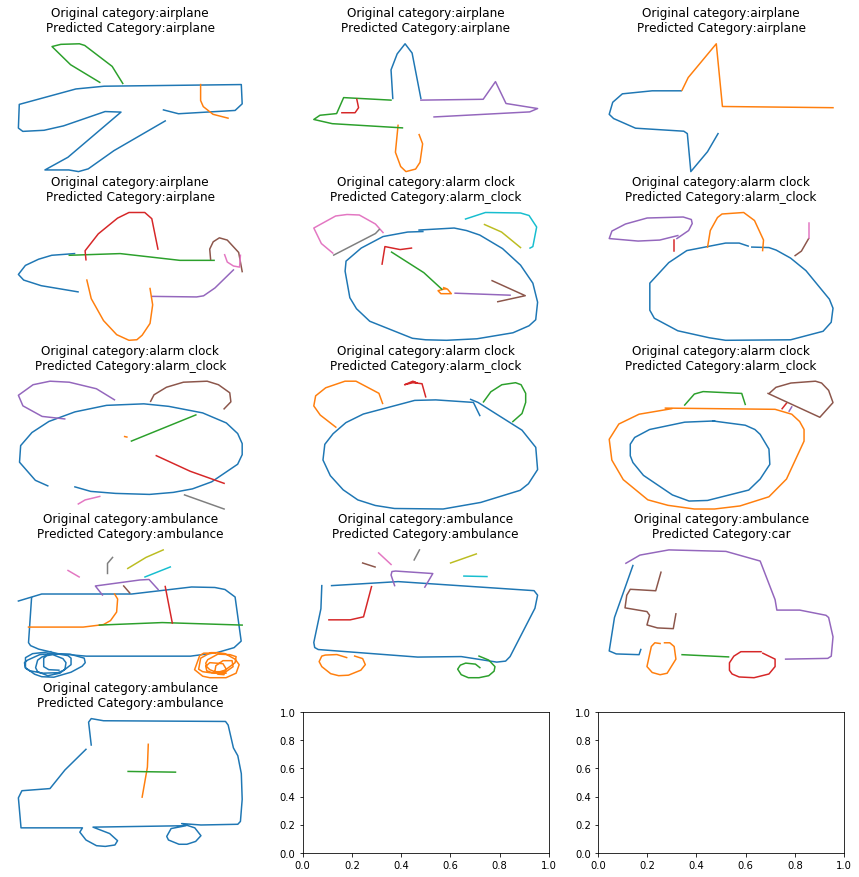

In [54]:
## predicting the sample data 
prediction = model.predict(file_data_array)
prediction = np.argmax(prediction,axis=1)

## visualising the data as images
f,axs= plt.subplots(5,3,frameon=False,figsize=(15,15))
for i,drawing in enumerate(sample_diagram_points):
    for j,strokes in enumerate(drawing):
        ax=axs[i//3,i%3]
        ax.plot(strokes[0],np.negative(strokes[1]))
        ax.set(title=('Original category:'+sample_df.iloc[i].word+'\nPredicted Category:'+categories[prediction[i]]))
        ax.axis('off')
plt.show()